In [1]:
from f_drosophila_infer import *
from f_train import *
from f_data_prep import *

In [2]:
data_all = np.loadtxt('../data_complete.txt')
data_all = data_all - np.median(data_all, axis=0)
all_bin = np.vsplit(data_all, 6)
all_init = np.vstack([all_bin[i] for i in range(5)])

complete_all = ([int(x) - 1 for x in open('../indices_complete.txt','r').readline().split()])
comp_ind = list(map(int, list((np.array(complete_all)[::6]-3)/6)))

### Append the predictor matrix with quadratic terms

In [3]:
quad_all = np.copy(data_all)

for i in range(len(comp_ind)-1):
    for j in range(i+1, len(comp_ind)):
        quad_all = np.hstack((quad_all, (data_all[:,comp_ind[i]]*data_all[:,comp_ind[j]])[:,None]))

all_quad_bin = np.vsplit(quad_all, 6)
quad_init = np.vstack([all_quad_bin[i] for i in range(5)])
all_diff = np.vstack([all_bin[i+1]-all_bin[i] for i in range(5)])

print('# of quadratic variables:', int(len(comp_ind)*(len(comp_ind)-1)/2))
print('Size of predictor:', quad_init.shape, '\nSize of target:', all_diff.shape)

# of quadratic variables: 351
Size of predictor: (30390, 450) 
Size of target: (30390, 99)


### Infer w, $\sigma$ and bias with $\lambda = 0.1$

In [4]:
w, sigma, bias = infer_drosophila_quad(quad_init, all_diff, power=1, l=0.1)
print(w.shape, bias.shape, sigma.shape)

(450, 99) (1, 99) (1, 99)


### predict gene$^{t+1}_{all}$ with tanh activation function and compare with the true gene$^{t+1}_{all}$

In [5]:
data_actual = np.vstack([all_bin[i+1] for i in range(5)])
data_pred = all_init + np.tanh(bias + quad_init.dot(w)) + sigma*npr.normal(size=(1,w.shape[1]))

E_all_0d1 = (np.sum(np.abs(data_pred - data_actual)**2, axis=0)/np.sum(np.abs(data_actual)**2, axis=0))**1/2

### with $\lambda=1$

In [6]:
w, sigma, bias = infer_drosophila_quad(quad_init, all_diff, power=1, l=1)
print(w.shape, bias.shape, sigma.shape)

data_actual = np.vstack([all_bin[i+1] for i in range(5)])
data_pred = all_init + np.tanh(bias + quad_init.dot(w)) + sigma*npr.normal(size=(1,w.shape[1]))

E_all_1 = (np.sum(np.abs(data_pred - data_actual)**2, axis=0)/np.sum(np.abs(data_actual)**2, axis=0))**1/2

(450, 99) (1, 99) (1, 99)


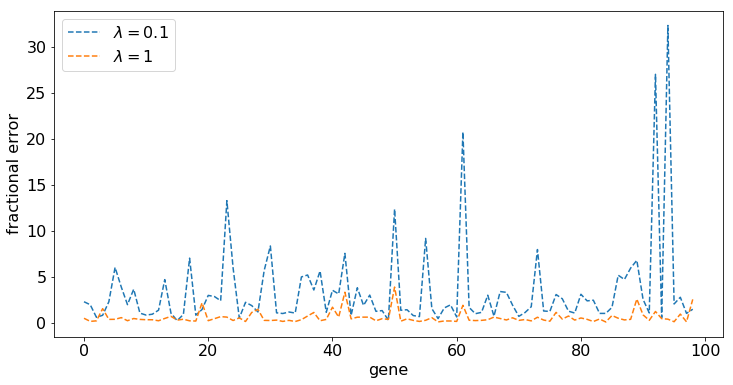

In [7]:
plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 16
plt.plot(range(data_pred.shape[1]), E_all_0d1, '--', label='$\lambda=0.1$')
plt.plot(range(data_pred.shape[1]), E_all_1, '--', label='$\lambda=1$')
# plt.plot(comp_ind, E[comp_ind], 'ko')
# plt.plot(comp_ind, comp_E, 'ro')
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.legend(loc='best')
plt.show()

### Use only 27 genes with complete temporal information
- append 27 predictors with (27*26)/2 quadratic terms

In [8]:
data_comp = np.copy(data_all[:, comp_ind])
comp_bin = np.vsplit(data_comp, 6)
quad_comp = np.copy(data_comp)

for i in range(len(comp_ind)-1):
    for j in range(i+1, len(comp_ind)):
        quad_comp = np.hstack((quad_comp, (quad_comp[:,i]*quad_comp[:,j])[:,None]))
        
comp_quad_bin = np.vsplit(quad_comp, 6)
quad_init = np.vstack([comp_quad_bin[i] for i in range(5)])
comp_diff = np.vstack([comp_bin[i+1] - comp_bin[i] for i in range(5)])

print('# of quadratic predictors:', int(len(comp_ind)*(len(comp_ind)-1)/2))
print('Size of predictor:', quad_init.shape, '\nSize of target', comp_diff.shape)

# of quadratic predictors: 351
Size of predictor: (30390, 378) 
Size of target (30390, 27)


### infer w, $\sigma$ and bias with Ridge regression, $\lambda=0.1$

In [9]:
w, sigma, bias = infer_drosophila_quad(quad_init, comp_diff, power=1, l=0.1)
print(w.shape, bias.shape, sigma.shape)

(378, 27) (1, 27) (1, 27)


### predict gene$^{t+1}_{complete}$ with tanh activation function and compare with the true gene$^{t+1}_{complete}$

In [10]:
data_actual = np.vstack([comp_bin[i+1] for i in range(5)])
data_pred = all_init[:, comp_ind] + np.tanh(bias + quad_init.dot(w)) + sigma*npr.normal(size=(1,w.shape[1]))

E_comp_0d1 = (np.sum(np.abs(data_pred - data_actual)**2, axis=0)/np.sum(np.abs(data_actual)**2, axis=0))**1/2

### with $\lambda = 1$

In [11]:
w, sigma, bias = infer_drosophila_quad(quad_init, comp_diff, power=1, l=1)
print(w.shape, bias.shape, sigma.shape)

data_actual = np.vstack([comp_bin[i+1] for i in range(5)])
data_pred = all_init[:, comp_ind] + np.tanh(bias + quad_init.dot(w)) + sigma*npr.normal(size=(1,w.shape[1]))

E_comp_1 = (np.sum(np.abs(data_pred - data_actual)**2, axis=0)/np.sum(np.abs(data_actual)**2, axis=0))**1/2

(378, 27) (1, 27) (1, 27)


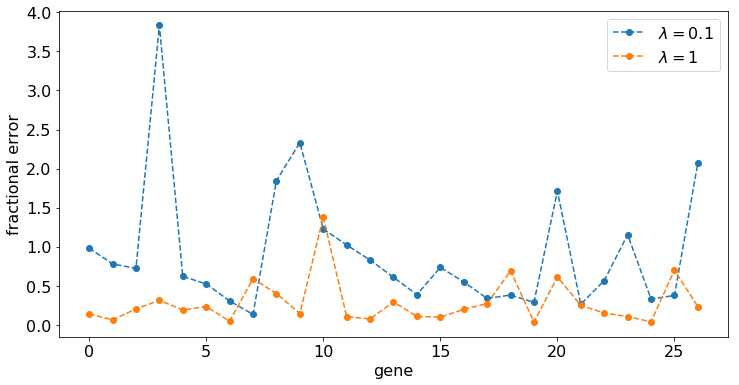

In [12]:
plt.figure(figsize=(12,6))
plt.plot(range(data_pred.shape[1]), E_comp_0d1, 'o--', label='$\lambda=0.1$')
plt.plot(range(data_pred.shape[1]), E_comp_1, 'o--', label='$\lambda=1$')
# plt.plot(comp_ind, E[comp_ind], 'ko')
# plt.plot(comp_ind, comp_E, 'ro')
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.legend(loc='best')
# plt.xlim(0,26)
# plt.ylim(0,1)
plt.show()

### error comparison between $g^{t+1}_{all}[\text{complete genes}]$ and $g^{t+1}_{complete}$

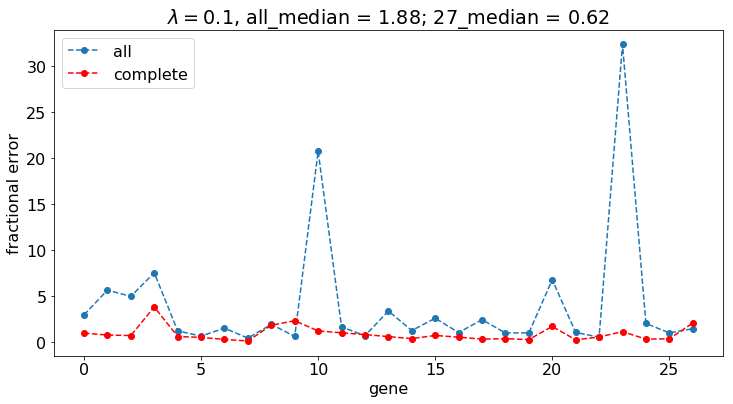

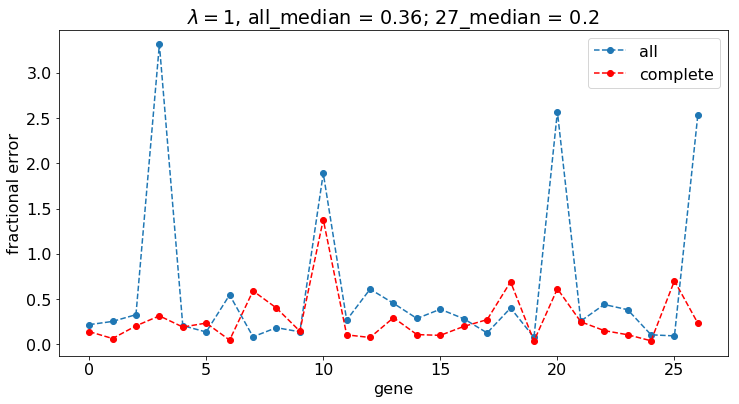

In [18]:
plt.figure(figsize=(12,6))
plt.plot(range(len(comp_ind)), E_all_0d1[comp_ind], 'o--', label='all')
plt.plot(range(len(comp_ind)), E_comp_0d1, 'ro--', label='complete')
# plt.plot(comp_ind, E[comp_ind], 'ko')
# plt.plot(comp_ind, comp_E, 'ro')
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.title('$\lambda=0.1$, all_median = %s; 27_median = %s'\
          %(round(np.median(E_all_0d1),2), round(np.median(E_comp_0d1),2)))
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(range(len(comp_ind)), E_all_1[comp_ind], 'o--', label='all')
plt.plot(range(len(comp_ind)), E_comp_1, 'ro--', label='complete')
# plt.plot(comp_ind, E[comp_ind], 'ko')
# plt.plot(comp_ind, comp_E, 'ro')
plt.xlabel('gene')
plt.ylabel('fractional error')
plt.title('$\lambda=1$, all_median = %s; 27_median = %s'\
          %(round(np.median(E_all_1),2), round(np.median(E_comp_1),2)))
plt.legend(loc='best')
plt.show()